In [1]:
import numpy as np

arr = np.load("ch2_ohr_ncp_20200825T1127278043_d_img_d18.npz", allow_pickle= True)['arr_0']

In [2]:
arr

array([[87, 85, 87, ...,  0,  0,  0],
       [90, 85, 87, ...,  0,  0,  0],
       [99, 92, 91, ..., 35, 31, 24],
       ...,
       [46, 49, 48, ..., 23, 19, 17],
       [42, 44, 40, ..., 24, 23, 22],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=uint8)

In [3]:
arr.shape

(93693, 12000)

In [4]:
arr = np.float32(arr)

In [5]:
# arr = arr[:18688,:2304]

In [6]:
arr.shape

(93693, 12000)

In [7]:
# Define the size of the 2D array
m, p = 93568, 11904

# Define the size of the 3D array
n = m * p // (128 * 128)
result = np.zeros((n, 128, 128))

# Convert the 2D array to a 3D array
for i in range(n):
    x = (i * 128) % p
    y = (i * 128) // p * 128
    result[i] = arr[y:y+128, x:x+128]/255

print(result.shape)

(67983, 128, 128)


In [8]:
result=np.reshape(result,(67983,128,128,1))

In [9]:
train = result[:10000]
test = result[10000:12000]

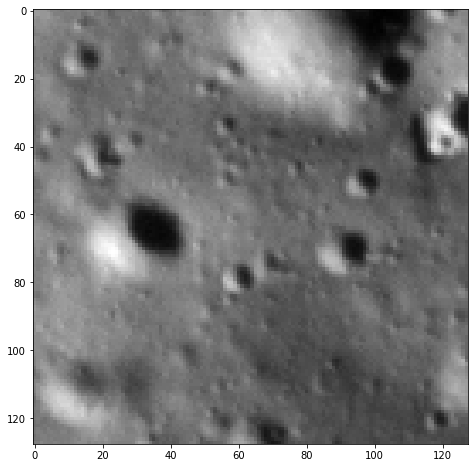

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(8, 8))
plt.imshow(train[677], cmap='gray')

In [11]:
import keras
import tensorflow 
from keras.utils import plot_model
from keras.layers import Input, Flatten, Dense, Conv2D, Conv2DTranspose, BatchNormalization, LeakyReLU, Dropout, Activation, Reshape, Lambda
from keras.models import Model
from keras.optimizers import Adam
from keras.utils import to_categorical
import keras.backend as K 
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D

ENCODER

In [12]:
encoder_input = Input(shape=(128,128,1), name='encoder_input')

In [13]:
x = encoder_input

In [14]:
n_layers_encoder = 3
input_dim = (128,128,1)
encoder_conv_filters = [32,32,64]
encoder_conv_kernel_size = [3,3,3]
encoder_conv_strides = [1,2,2]
decoder_conv_t_filters = [64,64,1]
decoder_conv_t_kernel_size = [3,3,3]
decoder_conv_t_strides = [2,2,1]


In [15]:
for i in range(n_layers_encoder):
    conv_layer = Conv2D(
    filters = encoder_conv_filters[i]
    , kernel_size = encoder_conv_kernel_size[i]
    , strides = encoder_conv_strides[i]
    , padding = 'same'
    , name = 'encoder_conv_' + str(i)
    )
    x = conv_layer(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

In [16]:
shape_before_flattening = K.int_shape(x)[1:]
encoder_output = Flatten()(x)

In [17]:
encoder = Model(encoder_input,encoder_output)


In [18]:
encoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 128, 128, 1)]     0         
                                                                 
 encoder_conv_0 (Conv2D)     (None, 128, 128, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 32)     128       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128, 128, 32)      0         
                                                                 
 encoder_conv_1 (Conv2D)     (None, 64, 64, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 64, 64, 32)       128       
 hNormalization)                                             

DECODER

In [19]:
# decoder_input = Input(shape=(4096,), name='encoder_output')

In [20]:
# x = Dense(np.prod(shape_before_flattening))(encoder_output) 
x = Reshape(shape_before_flattening)(encoder_output)

In [21]:
n_layers_decoder=3
for i in range(n_layers_decoder):
    conv_t_layer = Conv2DTranspose(
    filters = decoder_conv_t_filters[i]
    ,kernel_size = decoder_conv_t_kernel_size[i]
    ,strides = decoder_conv_t_strides[i]
    ,padding = 'same'
    ,name = 'decoder_conv_t_' + str(i)
    )
    x = conv_t_layer(x) 
    if (i < n_layers_decoder - 1):
        x = BatchNormalization()(x)
        x = LeakyReLU()(x)
    else:
        x = Activation('sigmoid')(x)


In [22]:
decoder_output = x

In [23]:
decoder = Model(encoder_output, decoder_output)

In [24]:
model = Model(encoder_input,decoder_output)

In [25]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 128, 128, 1)]     0         
                                                                 
 encoder_conv_0 (Conv2D)     (None, 128, 128, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 32)     128       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128, 128, 32)      0         
                                                                 
 encoder_conv_1 (Conv2D)     (None, 64, 64, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 64, 64, 32)       128       
 hNormalization)                                           

In [26]:
r_factor=1
kl_factor = 0.000001

def vae_r_loss(y_true, y_pred):
    r_loss = keras.losses.MeanSquaredError()(y_true, y_pred)
    return r_loss

def vae_kl_loss(y_true, y_pred):
    x=encoder(y_true)
    mu, log_var = tensorflow.split(x, num_or_size_splits=2, axis = 1)
    kl_loss = -0.5 * K.mean(1 + log_var - K.square(mu)- K.exp(log_var), axis = 1)
    return kl_loss

def vae_loss(y_true, y_pred):
    r_loss = vae_r_loss(y_true, y_pred)
    kl_loss = vae_kl_loss(y_true, y_pred)
    return r_factor*r_loss + kl_factor*kl_loss


In [27]:
optimizer = Adam()
model.compile(optimizer = optimizer, loss = vae_loss)

In [28]:
history = model.fit(train, train, batch_size= 100, shuffle= True, epochs= 10)

Epoch 1/10
100/100 [==============================] - 431s 4s/step - loss: 0.0028
Epoch 2/10
100/100 [==============================] - 411s 4s/step - loss: 3.1400e-04
Epoch 3/10
100/100 [==============================] - 388s 4s/step - loss: 3.5122e-04
Epoch 4/10
100/100 [==============================] - 397s 4s/step - loss: 2.4330e-04
Epoch 5/10
100/100 [==============================] - 381s 4s/step - loss: 2.3246e-04
Epoch 6/10
100/100 [==============================] - 389s 4s/step - loss: 2.2433e-04
Epoch 7/10
100/100 [==============================] - 380s 4s/step - loss: 2.0336e-04
Epoch 8/10
100/100 [==============================] - 375s 4s/step - loss: 1.7019e-04
Epoch 9/10
100/100 [==============================] - 380s 4s/step - loss: 1.7690e-04
Epoch 10/10
100/100 [==============================] - 388s 4s/step - loss: 2.0834e-04


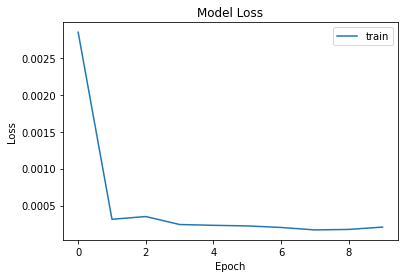

In [29]:
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [30]:
final = model.predict(
    test,
    batch_size = None,
    verbose = 'auto',
    steps = None,
    callbacks = None,
    max_queue_size = 10,
    workers = 1,
    use_multiprocessing=False
)

63/63 [==============================] - 22s 330ms/step
